In [1]:
from selenium import webdriver
from selenium.webdriver.common.by import By
import requests
import bs4
import os
import time
from selenium.webdriver.chrome.options import Options

options = Options()
options.add_argument("start-maximized")

In [2]:
# check if there is a folder named that stores the screped images, if not create one
folder_name = 'images'
if not os.path.isdir(folder_name):
    os.makedirs(folder_name)

In [3]:
def download_image(url, folder_name, num):
    
    # get the image url extracted from the scrapper
    response = requests.get(url)
    if response.status_code == 200:
        with open(os.path.join(folder_name, str(num) + ".jpg"), 'wb') as file:
            file.write(response.content)

In [4]:
chrome_driver_path = "C:/Users/ADMIN/Desktop/Drivers/chromedriver.exe"
driver = webdriver.Chrome(chrome_driver_path)

C:\Users\ADMIN\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: DeprecationWarning: executable_path has been deprecated, please pass in a Service object
  


In [5]:
search_url = 'https://www.google.com/search?q=furniture&source=lnms&tbm=isch'

In [6]:
driver.get(search_url)

In [7]:
# introduce a delay so the user can scroll to the end of the google page and load all images in the page
a = input('Waiting for user input to start')

Waiting for user input to start


In [8]:
# scroll all the way up the page and start clicking on things from the top of the page
# https://selenium-python.readthedocs.io/api.html?highlight=driver.execute_script()#selenium.webdriver.remote.webdriver.WebDriver.execute_script

driver.execute_script("window.scrollTo(0,0);")

In [9]:
# Gets the source of the current page. send all of the page source as a html to the variable
# https://selenium-python.readthedocs.io/api.html?highlight=page_source#selenium.webdriver.remote.webdriver.WebDriver.page_source

page_html = driver.page_source

<html lang="en" dir="ltr" itemscope="" itemtype="http://schema.org/SearchResultsPage"><head><script src="https://apis.google.com/_/scs/abc-static/_/js/k=gapi.gapi.en.fQLVS3SAB_U.O/m=gapi_iframes,googleapis_client/rt=j/sv=1/d=1/ed=1/rs=AHpOoo9-gtqpJORJvBFDdao_eAhWe8xjHw/cb=gapi.loaded_0" nonce="" async=""></script><base href="https://www.google.com/"><meta name="referrer" content="origin"><script data-id="_gd" nonce="">window.WIZ_global_data = {"DpimGf":false,"EP1ykd":["/_/*","/a/cpanel","/a/cpanel/*","/about/careers/applications-a","/about/careers/applications-a/*","/buzz/c","/buzz/c/*","/cameos","/cameos/*","/cbk","/cbk/*","/coronavirus-map","/coronavirus-map/*","/covid19-map","/covid19-map/*","/covid19/exposurenotifications/select","/covid19/exposurenotifications/select/*","/display-ads-user-messaging-embed","/display-ads-user-messaging-embed/*","/finance","/finance/*","/healthinsurance/immersive","/healthinsurance/immersive/*","/history","/history/*","/ig/c","/ig/c/*","/local/busine
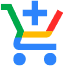
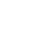
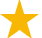
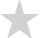
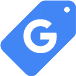
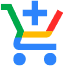
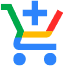
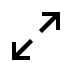
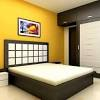
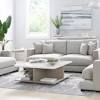
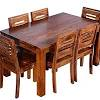
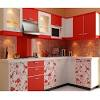
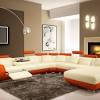
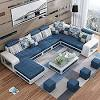
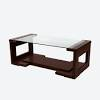
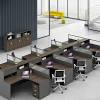
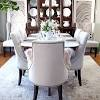
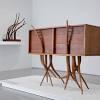
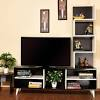
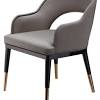
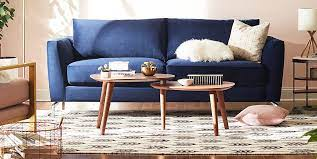
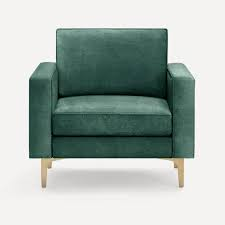
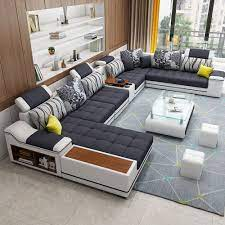
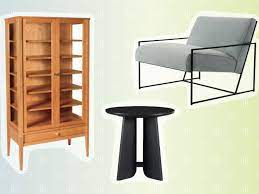
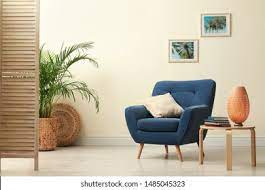
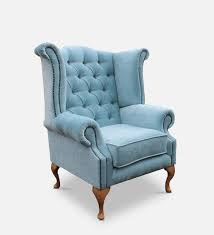
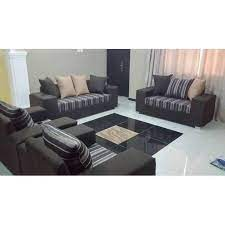
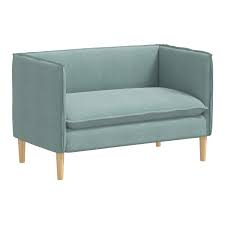
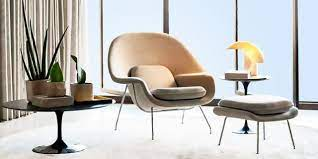
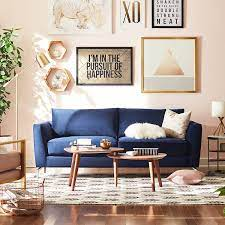
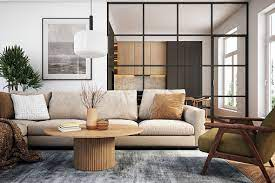
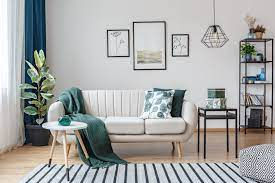
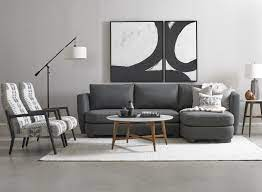
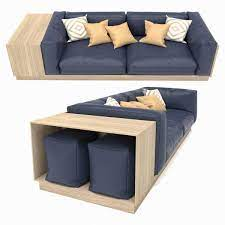
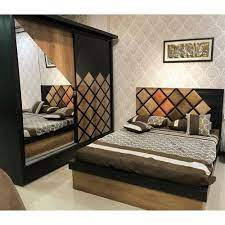
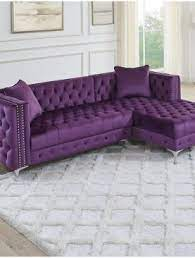
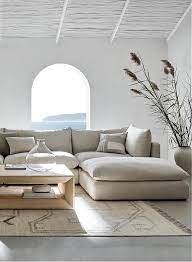
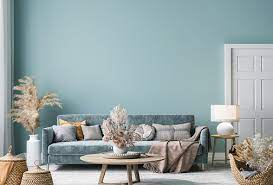
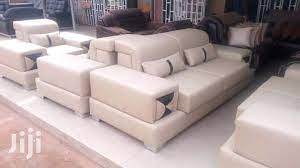
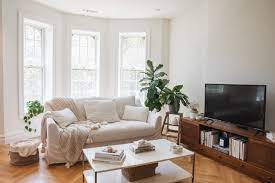

In [10]:
print(page_html)

In [11]:
# use beautiful soup to parse the html page source
page_soup = bs4.BeautifulSoup(page_html, "html5lib")

In [12]:
# navigate to the individual image containers of the google page
# find all containers that have a tag of div and a class of 'isv-r PNCib MSM1fd BUooTd'
containers = page_soup.find_all('div',{'class':"isv-r PNCib MSM1fd BUooTd"})

In [13]:
len_containers = len(containers)

In [14]:
# Xpath for Related searches container
#//*[@id="islrg"]/div[1]/div[25]
#//*[@id="islrg"]/div[1]/div[50]
#//*[@id="islrg"]/div[1]/div[75]
#//*[@id="islrg"]/div[1]/div[100]
#//*[@id="islrg"]/div[1]/div[125]

### Take care of Related Searches Widget

It was observed that after every 25 image loads from google, there's a related searches widget that has the same format XPATH format as the container holding actual images.  
This poses a problem as the container doesn't hold images but rather links to a separate page that doesn't follow the format of the page we're scrapping and eventually breaks the code.  
To fix this we have to ensure that we skip containers at every 25 intervals.

### Ensure we load images in higher resolution

We also observed that when we click on images in the google images page, the image is in a lower resolution and it takes some time before the image loads into a higher resolution image on the right side of the page.  
This is evident when we inspect the image url of the image in a container before we actually click on it and shortly after if it is clicked on or when its clicked on in offline mode. The observation is that the urls are thesame, which generally shows that the image is still in a low resolution.  
After some few seconds, the image is loaded to the right side of the screen (not always) but this time in higher resolution. And the image url of both resolutions changes.  
We'll consider this when loading images in order to know how long to wait for images before downloading them, to make sure we download images that are in higher resolutions.  
We'll iteratively check the image urls between the lower resolution image and the higher resolution, once the urls of the images are not thesame we know that the higher resolution image has been loaded and and we can go ahead to download the image in higher resolution

In [ ]:
# ensure every 25th container is skipped 
for i in range(1, len_containers+1):
    if i % 25 == 0:
        continue
    
    # get xPath format of the full image container
    img_container_x_path = f"""//*[@id="islrg"]/div[1]/div[{i}]"""
    
    # get the xPath of the actual preview image
    preview_img_xpath = f"""//*[@id="islrg"]/div[1]/div[{i}]/a[1]/div[1]/img"""
    
    # use driver to find the xpath of the preview image 
    preview_img_element = driver.find_element(by=By.XPATH, value=preview_img_xpath)
    
    # get the url of the preview preview image
    preview_img_url = preview_img_element.get_attribute("src")
    
    # click on the actual container xPath
    driver.find_element(by=By.XPATH, value=img_container_x_path).click()
    
    # get the current time  before running the while loop, 
    # this helps to check how long it takes before the high res image is loaded
    start_time = time.time()
    while True:
        
        # get the xPath of the full res image (we observed that the full res img xpath is same for all image containers)
        full_res_img_xpath = """//*[@id="Sva75c"]/div/div/div[3]/div[2]/c-wiz/div/div[1]/div[1]/div[2]/div/a/img"""
        full_res_img_element = driver.find_element(by=By.XPATH, value=full_res_img_xpath)
        
        # get the url of the full res image
        full_res_img_url = full_res_img_element.get_attribute("src")
        
        # check if the full res img url and the preview img url are not the thesame
        # once they are not the same, break the while loop and go ahead to download the full image res
        # since it means the full res image has been loaded
        if preview_img_url != full_res_img_url:
            break
            
        # if they are same, and the full res image fails to load after 12 seconds,
        # show a timeout warning and go ahead to download the low res image
        else:
            current_time = time.time()
            
            # check if the time difference between the preview image load and the full image load is greater than 12 seconds
            if current_time - start_time > 12:
                print('Timeout!!! Will download a lower resolution image and move onto the next one')
                break
    
    # download the images given the urls
    try:
        download_image(full_res_img_url, folder_name, i)
        print(f"Downloaded element {i} out of {len_containers} total. URL: {full_res_img_url}")
    except:
        print(f"Couldn't download an image {i}, continuing to download the next one")
                

Downloaded element 1 out of 400 total. URL: https://hips.hearstapps.com/hmg-prod.s3.amazonaws.com/images/amazon-rivet-furniture-1533048038.jpg?crop=1.00xw:0.502xh;0,0.423xh&resize=1200:*
Downloaded element 2 out of 400 total. URL: https://media.architecturaldigest.com/photos/5f4e9c54072307c75638c0f1/1:1/w_1280%2Cc_limit/Screen%2520Shot%25202020-09-01%2520at%25203.08.43%2520PM.png
Downloaded element 3 out of 400 total. URL: https://image.made-in-china.com/2f0j00EDdUwRjJysoK/Modern-Leisure-Sofa-Hotel-Living-Room-Office-Home-Furniture.jpg
Downloaded element 4 out of 400 total. URL: https://www.thespruce.com/thmb/D5tlxZEy_eXArVkGVilFzcVOI6o=/1333x1000/smart/filters:no_upscale()/SPR-HOME-8-best-made-in-america-furniture-1391263-HL-0229459920d14560b24183a6fd5880b5.jpg
Downloaded element 5 out of 400 total. URL: https://image.shutterstock.com/image-photo/stylish-room-interior-comfortable-furniture-260nw-1485045323.jpg
Downloaded element 6 out of 400 total. URL: https://ii1.pepperfry.com/media

Downloaded element 58 out of 400 total. URL: https://www.bassettfurniture.com/blog/images/6W26-0859-Fusion-SP19.jpg
Downloaded element 59 out of 400 total. URL: https://image.shutterstock.com/image-photo/books-lamp-on-rustic-cupboard-260nw-786280387.jpg
Downloaded element 60 out of 400 total. URL: https://static-uc.olist.ng/upload/20200404/r78jvyqiigx.jpg
Downloaded element 61 out of 400 total. URL: https://nigerianinfopedia.com.ng/wp-content/uploads/2019/12/furniture-company-in-nigeria.jpg
Downloaded element 62 out of 400 total. URL: https://www.elifemate.com/wp-content/uploads/2021/10/SE376-scaled.jpg
Timeout!!! Will download a lower resolution image and move onto the next one
Downloaded element 63 out of 400 total. URL: https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcT1xCpIzMeNzP5z17cCU9vsu4yTTfcqdGDetQ&usqp=CAU
Downloaded element 64 out of 400 total. URL: https://sunnewsonline.com/wp-content/uploads/2017/05/WTPcustomisedfurniture.jpg
Downloaded element 65 out of 400 total. UR

Downloaded element 113 out of 400 total. URL: https://static-uc.olist.ng/upload/20191212/fngtscwa3gh.jpg
Downloaded element 114 out of 400 total. URL: https://pictures-nigeria.jijistatic.com/45837167_img-20200528-wa0012_1080x608.jpg
Downloaded element 115 out of 400 total. URL: https://www.lane7.ng/assets/living/bookshelves-lagos-abuja-phc-nigeria-lane7-cc7d6c63e11b272e1a8ba4cbf68a8c334f0e86e5b907240a3c01e7ad2cc62c0b.jpg
Downloaded element 116 out of 400 total. URL: https://media.timbu.com/poi/3546/15109489_1159348237484588_565390629548076582_n-3546-583741edc4787.jpg?w=132&h=132
Downloaded element 117 out of 400 total. URL: https://i2.wp.com/largelifedesigns.com/wp-content/uploads/2018/07/Purity-Series-6-Seater-Sectional-Sofa.jpg?resize=600%2C600&ssl=1
Downloaded element 118 out of 400 total. URL: https://lagoslink.com/wp-content/uploads/2017/12/furniture-stores-in-lagos.png
Downloaded element 119 out of 400 total. URL: https://ii1.pepperfry.com/media/catalog/product/b/a/1600x800/bali-

Downloaded element 167 out of 400 total. URL: https://baffihomeng.com/wp-content/uploads/2022/01/kale-bed-set-1.jpg
Downloaded element 168 out of 400 total. URL: https://images-eu.ssl-images-amazon.com/images/G/31/IMG21/Furniture/2021/Headder-Baner-1500-x-800-desktop_V1.gif
Downloaded element 169 out of 400 total. URL: https://sp-ao.shortpixel.ai/client/to_auto,q_glossy,ret_img,w_300,h_300/https://mcgankons.com/wp-content/uploads/2019/10/ddd4-247x296.png
Downloaded element 170 out of 400 total. URL: https://cdn-eu.dynamicyield.com/api/9877105/images/1f8ea28dfd4ef__W21sp23_TransitionalRugs_01x.jpg
Timeout!!! Will download a lower resolution image and move onto the next one
Downloaded element 171 out of 400 total. URL: https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcTcNpf2-QOZNsVImTQRAZQaLHUc1zD9mx_tQw&usqp=CAU
Downloaded element 172 out of 400 total. URL: https://www.amartfurniture.com.au/on/demandware.static/-/Library-Sites-amart-shared-library/default/dw8bc4d0e2/images/AASLIDERS

Downloaded element 217 out of 400 total. URL: https://www.knoxfurn.com/cid101/css/20507/images/hero-mobile.jpg
Downloaded element 218 out of 400 total. URL: https://www.archiproducts.com/images/category-b/779@1x.jpg
Downloaded element 219 out of 400 total. URL: https://www.indonesiacontemporary-furniture.com/wp/wp-content/uploads/2021/04/Kastara-Bed-Room-Set-Indonesia-Contemporary-Furniture.jpg
Downloaded element 220 out of 400 total. URL: https://cdn.shopify.com/s/files/1/0047/2534/2319/collections/sofas_large.png?v=1630692707
Downloaded element 221 out of 400 total. URL: https://joybird.com/i/joybird2.imgix.net/user-uploads-staging/LP-Tile-Floor-Found-Thumb-1629324219569.jpeg?auto=format%2Ccompress&fit=crop&crop=entropy&ixlib=react-9.1.2
Downloaded element 222 out of 400 total. URL: https://www.limemodernliving.co.uk/user/Homepage%20Designs/MOBILE-LINK-Free-Delivery-2-up.jpg
Downloaded element 223 out of 400 total. URL: https://images.dwell.co.uk/i/dwell/dw_search_by_room_lounge.jpg


Downloaded element 274 out of 400 total. URL: https://1i9wu42vzknf1h4zwf2to5aq-wpengine.netdna-ssl.com/wp-content/uploads/2021/12/CE_ENTRY_DETAIL2-scaled.jpg
Downloaded element 276 out of 400 total. URL: https://images.furniture.com/fm/prod/original/main/home-hero_out.jpg
Downloaded element 277 out of 400 total. URL: https://craftsmanfurniture.com.ng/wp-content/uploads/2020/04/Craftsman-furniture-kariba-Divan2-for-slider.png
Downloaded element 278 out of 400 total. URL: https://www.furniture-rental-tokyo.com/img/slider/1600x700-2f-2-s.jpg
Downloaded element 279 out of 400 total. URL: https://www.daro-cane.co.uk/wp-content/uploads/slider/cache/2324e525f4ebe306849e9275185ae7f2/experts-cane-and-rattan-furniture.jpg
Downloaded element 280 out of 400 total. URL: https://wakefit-co.s3.ap-south-1.amazonaws.com/img/product-thumbnails/liberica-coffee-table-lifestyle-rectangle.jpg
Downloaded element 281 out of 400 total. URL: https://www.klaussner.com/cid641/css/1235/images/hp-tile-living-room.j

Downloaded element 334 out of 400 total. URL: https://linea-inc.com/images/made/images/subpromo/Professionals-Sup-Promo-hq-3_620_354_60_s_c1.jpg
Downloaded element 335 out of 400 total. URL: https://www.betterhomeindia.com/wp-content/uploads/2019/05/banner-fb-po6.png
Downloaded element 336 out of 400 total. URL: https://d3tskdc1t7oml9.cloudfront.net/media/wysiwyg/smartwave/porto/homepage/03/content/welcome_2021.jpg
Downloaded element 337 out of 400 total. URL: https://www.furniture-republic.com.ph/sites/default/files/300843_Open.jpg
Downloaded element 338 out of 400 total. URL: https://cdn.shopify.com/s/files/1/2458/6479/files/sofaicon_1080x1080.png?v=1636398680
Downloaded element 339 out of 400 total. URL: https://www.thejoinery.com/sites/default/files/styles/full_slide/public/slides/Shakerkentonset.jpg?itok=nh_q3PG4
Downloaded element 340 out of 400 total. URL: https://assets-news.housing.com/news/wp-content/uploads/2020/09/15183141/Types-of-wood-used-for-making-furniture-in-India-FB